# Multiple Timeseries Forecasting with Nixtla

## Installing Requirements

Activate a Python environment and install the following
```
pip install pandas
pip install numpy
pip install darts
pip install matplotlib
pip install -U "gluonts[torch]==0.11.0" "optuna~=2.10.0"
pip install ipykernel
pip install --upgrade nbformat
pip install lightgbm xgboost
pip install seaborn
pip install distributed
pip install datasetsforecast
pip install darts
pip install mlforecast
pip install statsforecast
```

In [39]:
%%capture
!pip install pandas
!pip install numpy
!pip install darts
!pip install matplotlib
!pip install -U "gluonts[torch]==0.11.0" "optuna~=2.10.0"
!pip install ipykernel
!pip install --upgrade nbformat
!pip install lightgbm xgboost
!pip install seaborn
!pip install distributed
!pip install datasetsforecast
!pip install darts
!pip install mlforecast
!pip install statsforecast

## Import packages

In [40]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset

In this tutorial, we will train and evaluate multiple time-series forecasting models using the [Store Item Demand Forecasting Challenge dataset from Kaggle](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=train.csv). This dataset has 10 different stores and each store has 50 items, i.e. total of 500 daily level time series data for five years (2013–2017).

# Download data

* Download the train.csv from https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=train.csv.
* Create a `./data` directory inside the directory of this Python notebook
* Save the train.csv inside the `./data` directory

# Load data


In [41]:
data = pd.read_csv("./data/train.csv", index_col=0)
data = data.reset_index()
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [42]:
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns")

The dataset has 913000 rows and 4 columns


# Data fields

* date - Date of the sale data. There are no holiday effects or store closures.
* store - Store ID
* item - Item ID
* sales - Number of items sold at a particular store on a particular date.

In [43]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


* We don't have any negative "sales" values
* We need to convert "store" and "item" columns to type string

# Reduce the amount of data

For simplicity & speed, we will only keep data from the first 2 out of the 10 stores

In [44]:
data = data.loc[data["store"] <= 2]

In [45]:
print(f"The dataset now has {data.shape[0]} rows and {data.shape[1]} columns")

The dataset now has 182600 rows and 4 columns


## Convert "store" and "item" columns to type string

In [46]:
data[["store", "item"]] = data[["store", "item"]].astype(str)

## Check for duplicate rows

In [47]:
count_duplicate_rows = len(data)-len(data.drop_duplicates())
print(f"There are {count_duplicate_rows} duplicate rows")

There are 0 duplicate rows


There are no duplicate rows

# Create a new column by concatenating "store" and "item" columns

In [48]:
data["store_item"] = data["store"] + "_" + data["item"]

# Convert date column to datetime

In [49]:
data["date"] = pd.to_datetime(data["date"]) 

# Calculate total rooms booked per date, hotel name and room type

In [50]:
item_sales_per_date = data.groupby(["date","store_item"])["sales"].aggregate("sum")
item_sales_per_date = item_sales_per_date.reset_index()
item_sales_per_date.columns = ["date","store_item","sales"]
item_sales_per_date = item_sales_per_date.sort_values("date", ascending=True)
item_sales_per_date.head()

,date,store_item,sales
0,2013-01-01,1_1,13
72,2013-01-01,2_3,19
71,2013-01-01,2_29,50
70,2013-01-01,2_28,45
69,2013-01-01,2_27,17


In [51]:
item_sales_per_date.tail()

,date,store_item,sales
182527,2017-12-31,1_34,32
182526,2017-12-31,1_33,61
182524,2017-12-31,1_31,48
182535,2017-12-31,1_41,25
182599,2017-12-31,2_9,75


# Plot total sales for all products over time

<Axes: xlabel='date'>

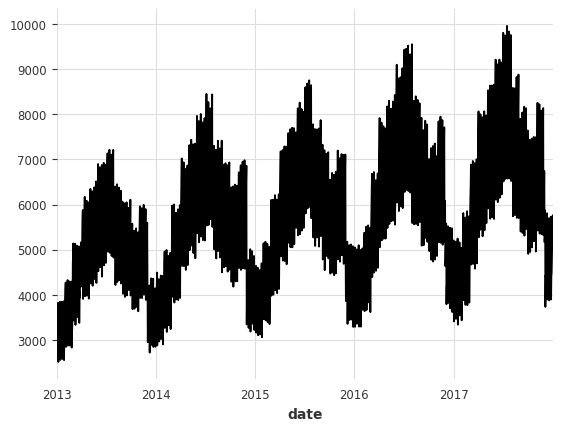

In [52]:
total_sales_per_date = item_sales_per_date.groupby(["date"])["sales"].aggregate("sum")
total_sales_per_date.plot()

## Not all items sell every day

* For each "store_item" value add all the missing "date" values and fill in "sales" with 0s

## Generate an index with all combinations of "date" and "store_item" values

In [53]:
multiindex = list(zip(item_sales_per_date["date"], item_sales_per_date["store_item"]))
multiindex = pd.MultiIndex.from_tuples(multiindex, names=('index_1', 'index_2'))

In [54]:
dataset = item_sales_per_date.copy()
dataset.index = multiindex

In [55]:
import itertools

idx_dates = list(pd.date_range(min(item_sales_per_date["date"]), max(item_sales_per_date["date"])))
idx_ids = list(dataset["store_item"].unique())
idx = list(itertools.product(idx_dates, idx_ids))
dataset = dataset.reindex(idx, None)
dataset = dataset.reset_index()
dataset.head()

/var/folders/rn/j1t3lrd938bf8zng2m3h5nlh0000gn/T/ipykernel_7581/3944406039.py:6: FutureWarning:

Interpreting call
	'.reindex(a, b)' as 
	'.reindex(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise a 'TypeError'.



,index_1,index_2,date,store_item,sales
0,2013-01-01,1_1,2013-01-01,1_1,13
1,2013-01-01,2_3,2013-01-01,2_3,19
2,2013-01-01,2_29,2013-01-01,2_29,50
3,2013-01-01,2_28,2013-01-01,2_28,45
4,2013-01-01,2_27,2013-01-01,2_27,17


### For each "store_item" value fill add all the missing "date" values and fill in "sales" with 0s

In [56]:
dataset["date"] = dataset["date"].fillna(dataset["index_1"])
dataset["store_item"] = dataset["store_item"].fillna(dataset["index_2"])
dataset["sales"] = dataset["sales"].fillna(0)
dataset = dataset.drop(columns=["index_1", "index_2"])
dataset = dataset.set_index("date")
dataset.index.name = "date"
dataset.head()

,store_item,sales
date,,
2013-01-01,1_1,13
2013-01-01,2_3,19
2013-01-01,2_29,50
2013-01-01,2_28,45
2013-01-01,2_27,17


# Create the dataset that we will use for training the forecasting models

In [57]:
# Rename columns to match the Nixtlaverse's expectations
# The 'store_item' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'sales' becomes 'y' representing the target variable we want to forecast
# Y_df = dataset.query('unique_id.str.startswith("6_46")').copy()
Y_df = dataset.copy()
Y_df = Y_df.reset_index()
Y_df = Y_df.rename(columns={
    'store_item': 'unique_id', 
    'date': 'ds', 
    'sales': 'y'
})
Y_df['y'] = Y_df['y'].astype(int)
# Convert the 'ds' column to datetime format to ensure proper handling of date-related operations in subsequent steps
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.tail()

,ds,unique_id,y
182595,2017-12-31,1_36,71
182596,2017-12-31,1_35,55
182597,2017-12-31,1_34,32
182598,2017-12-31,1_33,61
182599,2017-12-31,1_42,27


In [58]:
Y_df['unique_id'] = Y_df['unique_id'].astype(str)

In [59]:
%%capture
!pip install tqdm

In [60]:
from tqdm.autonotebook import tqdm
from statsforecast import StatsForecast
# Feature: plot random series for EDA
StatsForecast.plot(Y_df)

# Check for seasonality in the total number of 'sales' per 'date'

In [61]:
import darts
from darts import TimeSeries

In [62]:
seasonality_check_data = total_sales_per_date.reset_index()
seasonality_check_data = seasonality_check_data.set_index("date")
seasonality_check_data_series = TimeSeries.from_times_and_values(seasonality_check_data.index, seasonality_check_data["sales"].values)

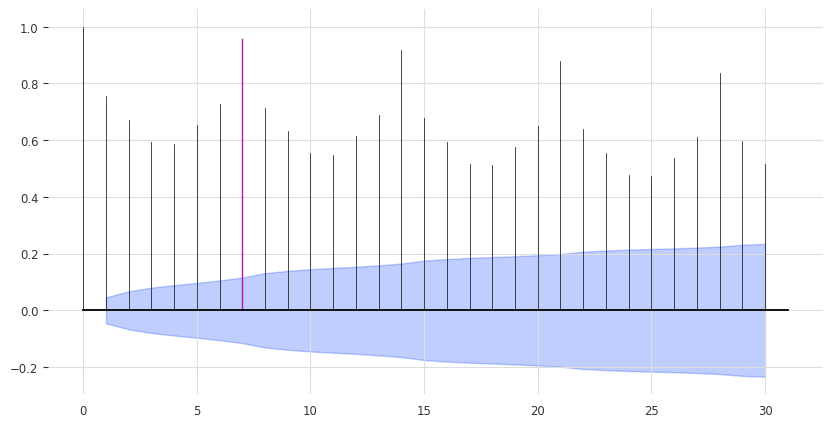

In [63]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(seasonality_check_data_series, m=7, alpha=0.05, max_lag=30)

The ACF presents a spike at x in [1, 7, 14, 21], which suggests a weekly seasonality trend (highlighted). The blue zone determines the significance of the statistics for a confidence level of $\alpha = 5\%$. We can also run a statistical check of seasonality for each candidate period `m`.

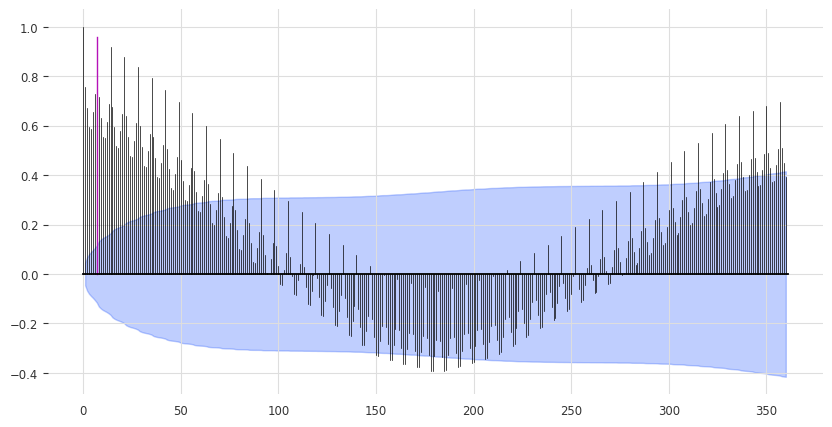

In [64]:
plot_acf(seasonality_check_data_series, m=7, alpha=0.05, max_lag=12*30)

We also have 6 months seasonality

## We will train multiple Statistical & ML models and evaluate which one performs best

# Create forecasts with Stats & Ml methods.

# Stats Methods with StatsForecast

In [65]:
# Import necessary models from the statsforecast library
from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive,
    # Naive: A simple model that uses the last observed value as the forecast
    Naive,
    # HistoricAverage: This model uses the average of all historical data as the forecast
    HistoricAverage,
    # CrostonOptimized: A model specifically designed for intermittent demand forecasting
    CrostonOptimized,
    # ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand
    ADIDA,
    # IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation
    IMAPA,
    # AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
    AutoETS
)

In [66]:
# horizon is the number of days in the future for which we will make a forecast
horizon = 30
# the seasonality window is 7 because we have weekly seasonality
season_length = 7
# the number of days that the model will use to make a forecast 
window_size = 6*30
models = [
    SeasonalNaive(season_length=season_length),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=season_length)
]

In [67]:
# Instantiate the StatsForecast class
sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq='D',  # The frequency of the time series data (in this case, 'D' stands for daily frequency)
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

In [68]:
from time import time

# Get the current time before forecasting starts, this will be used to measure the execution time
init = time()

# Call the forecast method of the StatsForecast instance to predict the next horizon days
# Level is set to [90], which means that it will compute the 90% prediction interval
fcst_df = sf.forecast(df=Y_df, h=horizon, level=[90])

# Get the current time after the forecasting ends
end = time()

# Calculate and print the total time taken for the forecasting in minutes
print(f'Forecast Minutes: {(end - init) / 60}')

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Forecast Minutes: 0.9659132162729899


In [69]:
fcst_df.head()

,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,CrostonOptimized,ADIDA,IMAPA,AutoETS,AutoETS-lo-90,AutoETS-hi-90
unique_id,,,,,,,,,,,,,,,,
1_1,2018-01-01,13.0,-9.95164,35.951641,23.0,11.348498,34.651501,19.971523,8.880493,31.062553,17.644085,17.644085,17.644085,13.276491,5.583838,20.743385
1_1,2018-01-02,16.0,-6.95164,38.951641,23.0,6.522288,39.477711,19.971523,8.880493,31.062553,17.644085,17.644085,17.644085,15.610193,8.173580,23.057755
1_1,2018-01-03,14.0,-8.95164,36.951641,23.0,2.819006,43.180992,19.971523,8.880493,31.062553,17.644085,17.644085,17.644085,16.068558,8.473478,23.472872
1_1,2018-01-04,19.0,-3.95164,41.951641,23.0,-0.303004,46.303005,19.971523,8.880493,31.062553,17.644085,17.644085,17.644085,16.683046,9.271523,24.447401
1_1,2018-01-05,15.0,-7.95164,37.951641,23.0,-3.053550,49.053551,19.971523,8.880493,31.062553,17.644085,17.644085,17.644085,17.999359,10.357993,25.916876


# ML Methods with MLForecast

In [70]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean

In [71]:
# Import the necessary models from various libraries

# LGBMRegressor: A gradient boosting framework that uses tree-based learning algorithms from the LightGBM library
from lightgbm import LGBMRegressor

# XGBRegressor: A gradient boosting regressor model from the XGBoost library
from xgboost import XGBRegressor

# LinearRegression: A simple linear regression model from the scikit-learn library
from sklearn.linear_model import LinearRegression

In [72]:
# Instantiate the MLForecast object
mlf = MLForecast(
    models=[LGBMRegressor(max_depth=10), XGBRegressor(max_depth=10, eval_metric='rmse'), LinearRegression()],  # List of models for forecasting: LightGBM, XGBoost and Linear Regression
    freq='D',  # Frequency of the data - 'D' for daily frequency
    lags=list(range(1, 7)),  # Specific lags to use as regressors: 1 to 6 days
    lag_transforms = {
        1:  [expanding_mean],  # Apply expanding mean transformation to the lag of 1 day
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week', 'dayofyear'],  # Date features to use as regressors
)

In [73]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of window_size days
mlf.fit(Y_df, prediction_intervals=PredictionIntervals(window_size=window_size))

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')

MLForecast Minutes: 0.3328384002049764


In [74]:
fcst_mlf_df = mlf.predict(horizon=horizon, level=[90])

In [75]:
fcst_mlf_df.head()

,unique_id,ds,LGBMRegressor,XGBRegressor,LinearRegression,LGBMRegressor-lo-90,LGBMRegressor-hi-90,XGBRegressor-lo-90,XGBRegressor-hi-90,LinearRegression-lo-90,LinearRegression-hi-90
0,1_1,2018-01-01,13.329638,11.704878,8.675110,5.270473,21.388803,4.914519,18.495237,5.612991,11.737228
1,1_1,2018-01-02,14.931276,14.586840,11.344208,-7.206398,37.068950,-0.771513,29.945192,-11.195117,33.883533
2,1_1,2018-01-03,15.546220,15.210465,13.980682,-15.789568,46.882009,-17.707149,48.128080,-16.309070,44.270435
3,1_1,2018-01-04,16.796155,17.746359,17.576263,-39.802248,73.394558,-44.107404,79.600121,-37.253653,72.406180
4,1_1,2018-01-05,19.286461,19.877424,22.591766,-5.928943,44.501865,-7.104265,46.859114,0.037720,45.145813


# Forecast plots 

Per store, item and forecast model

In [76]:
fcst_df = fcst_df.merge(fcst_mlf_df, how='left', on=['unique_id', 'ds'])

In [77]:
sf.plot(Y_df, fcst_df, max_insample_length=30)

# Validate Model’s Performance

## Cross Validation in StatsForecast

In [78]:
init = time()
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=3, step_size=horizon, level=[90])
end = time()
print(f'CV Minutes: {(end - init) / 60}')

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


CV Minutes: 2.01016796429952


## Cross Validation in MLForecast

In [79]:
init = time()
cv_mlf_df = mlf.cross_validation(
    data=Y_df, 
    window_size=horizon, 
    n_windows=3, 
    step_size=horizon, 
    level=[90],
)
end = time()
print(f'CV Minutes: {(end - init) / 60}')


/Users/evagian/.pyenv/versions/3.9.16/envs/multiple_timeseries_forecasting_medium_2/lib/python3.9/site-packages/mlforecast/forecast.py:576: UserWarning:

Excuting `cross_validation` after `fit` can produce unexpected errors

/Users/evagian/.pyenv/versions/3.9.16/envs/multiple_timeseries_forecasting_medium_2/lib/python3.9/site-packages/mlforecast/forecast.py:468: UserWarning:

Please rerun the `fit` method passing a proper value to prediction intervals to compute them.

/Users/evagian/.pyenv/versions/3.9.16/envs/multiple_timeseries_forecasting_medium_2/lib/python3.9/site-packages/mlforecast/forecast.py:468: UserWarning:

Please rerun the `fit` method passing a proper value to prediction intervals to compute them.



CV Minutes: 0.4411295692125956


/Users/evagian/.pyenv/versions/3.9.16/envs/multiple_timeseries_forecasting_medium_2/lib/python3.9/site-packages/mlforecast/forecast.py:468: UserWarning:

Please rerun the `fit` method passing a proper value to prediction intervals to compute them.



# Plot CV

In [80]:
cv_df = cv_df.merge(cv_mlf_df.drop(columns=['y']), how='left', on=['unique_id', 'ds', 'cutoff'])

In [81]:
cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,Naive,Naive-lo-90,Naive-hi-90,...,HistoricAverage-hi-90,CrostonOptimized,ADIDA,IMAPA,AutoETS,AutoETS-lo-90,AutoETS-hi-90,LGBMRegressor,XGBRegressor,LinearRegression
0,1_1,2017-10-03,2017-10-02,18.0,18.0,-4.933848,40.933849,12.0,0.372548,23.627453,...,31.117146,23.097826,23.097826,23.097826,20.748404,13.069439,28.202011,20.986565,21.120430,16.106079
1,1_1,2017-10-04,2017-10-02,15.0,27.0,4.066152,49.933849,12.0,-4.443700,28.443701,...,31.117146,23.097826,23.097826,23.097826,21.448473,14.038701,28.891298,21.331512,20.119049,18.031067
2,1_1,2017-10-05,2017-10-02,20.0,23.0,0.066152,45.933849,12.0,-8.139338,32.139339,...,31.117146,23.097826,23.097826,23.097826,22.151293,14.596908,29.561945,22.839414,21.601461,21.938843
3,1_1,2017-10-06,2017-10-02,19.0,28.0,5.066152,50.933849,12.0,-11.254905,35.254906,...,31.117146,23.097826,23.097826,23.097826,24.102106,16.697777,31.844584,23.958055,25.116436,25.472656
4,1_1,2017-10-07,2017-10-02,22.0,30.0,7.066152,52.933849,12.0,-13.999773,37.999775,...,31.117146,23.097826,23.097826,23.097826,26.270029,18.665735,34.179325,24.585000,24.807795,28.831360


In [82]:
cutoffs = cv_df['cutoff'].unique()


## Visualize cross validation splits for a specific unique_id

In [83]:
for cutoff in cutoffs:
    img = sf.plot(
        Y_df, 
        cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']), 
        max_insample_length=30*4, 
        unique_ids=['1_1'],
    )

# Aggregate sales forecasts for all items

In [84]:
agg_cv_df = cv_df.loc[:,~cv_df.columns.str.contains('hi|lo')].groupby(['ds', 'cutoff']).sum(numeric_only=True).reset_index()
agg_cv_df.insert(0, 'unique_id', 'Total sales (all items)')


In [85]:
agg_Y_df = Y_df.groupby(['ds']).sum(numeric_only=True).reset_index()
agg_Y_df.insert(0, 'unique_id', 'Total sales (all items)')

In [86]:
for cutoff in cutoffs:
    img = sf.plot(
        agg_Y_df, 
        agg_cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
        max_insample_length=30*4,
    )


# Evalute forecasts per store_item and CV window

In [87]:
from typing import List, Callable

from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine
from datasetsforecast.losses import mse, mae, smape, mape

In [88]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [89]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df = cv_df.reset_index()
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

Let’s cleate a dask client.

In [90]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})


The transform function takes the evaluate functions and applies it to each combination of time series (unique_id) and cross validation window (cutoff) using the dask client we created before.


In [91]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, mape, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)

In [92]:
evaluation_df.head()


,unique_id,cutoff,metric,SeasonalNaive,Naive,HistoricAverage,CrostonOptimized,ADIDA,IMAPA,AutoETS,LGBMRegressor,XGBRegressor,LinearRegression
0,1_26,2017-12-01,mse,189.633331,98.033333,125.793800,208.257904,208.257904,208.257904,157.573486,565.202942,525.581421,1664.116455
1,1_26,2017-12-01,mae,11.633333,8.700000,9.721529,12.208736,12.208736,12.208736,10.930923,22.293240,20.797604,38.954525
2,1_26,2017-12-01,mape,35.755207,26.532656,31.262075,40.555935,40.555935,40.555935,34.513111,67.545776,62.672226,114.718643
3,1_26,2017-12-01,smape,28.500648,23.340303,25.650661,30.775007,30.775007,30.775007,27.640188,47.732746,44.942799,69.370956
4,1_3,2017-12-01,mse,106.166664,50.900002,74.261719,114.982178,114.982178,114.982178,98.668747,238.811630,305.071228,943.499451


In [93]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['unique_id','cutoff', 'metric']).mean(numeric_only=True)

SeasonalNaive       Naive  HistoricAverage  \
unique_id cutoff     metric                                               
1_1       2017-10-02 mae          6.333333    9.633333         4.048694   
                     mape        32.008389   42.452873        20.500309   
                     mse         52.000000  112.900002        26.100897   
                     smape       29.412838   54.928314        19.620483   
          2017-11-01 mae          5.433333    7.100000         4.973650   
...                                    ...         ...              ...   
2_9       2017-11-01 smape       18.542643   17.053913        22.589777   
          2017-12-01 mae         24.466667   11.166667        12.115143   
                     mape        47.516216   18.910025        26.211300   
                     mse        777.533325  183.766663       225.511887   
                     smape       36.404957   21.065845        21.495785   

                             CrostonOptimized       ADIDA       IMAPA  \
unique_id cutoff     metric                                             
1_1       2017-10-02 mae             4.005797    4.005797    4.005797   
                     mape           23.324617   23.324617   23.324617   
                     mse            26.682756   26.682756   26.682756   
                     smape          19.235546   19.235546   19.235546   
          2017-11-01 mae             4.530332    4.530332    4.530332   
...                                       ...         ...         ...   
2_9       2017-11-01 smape          18.462778   18.462778   18.462778   
          2017-12-01 mae            20.834414   20.834414   20.834414   
                     mape           43.380859   43.380859   43.380859   
                     mse           540.985046  540.985046  540.985046   
                     smape          33.444027   33.444027   33.444027   

                                AutoETS  LGBMRegressor  XGBRegressor  \
unique_id cutoff     metric                                            
1_1       2017-10-02 mae       3.619618       3.521449      3.702634   
                     mape     20.203566      20.350691     19.863106   
                     mse      18.272795      19.097733     18.152235   
                     smape    17.812929      17.288076     18.430719   
          2017-11-01 mae       4.069747       4.240177      3.956506   
...                                 ...            ...           ...   
2_9       2017-11-01 smape    13.871297      23.943962     41.310276   
          2017-12-01 mae      21.479845       8.695793     13.496109   
                     mape     41.594486      14.652188     24.489933   
                     mse     493.400055     138.035370    265.246460   
                     smape    33.716820      16.779236     29.656071   

                             LinearRegression  
unique_id cutoff     metric                    
1_1       2017-10-02 mae             5.191331  
                     mape           25.506079  
                     mse            35.982857  
                     smape          23.132683  
          2017-11-01 mae             4.942663  
...                                       ...  
2_9       2017-11-01 smape          25.297966  
          2017-12-01 mae            10.121236  
                     mape           19.544510  
                     mse           136.701233  
                     smape          17.776690  

[1200 rows x 10 columns]

# Distribution of errors

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')
evaluation_df_melted

,unique_id,cutoff,metric,model,error
0,1_26,2017-12-01,mse,SeasonalNaive,189.633331
1,1_26,2017-12-01,mae,SeasonalNaive,11.633333
2,1_26,2017-12-01,mape,SeasonalNaive,35.755207
3,1_26,2017-12-01,smape,SeasonalNaive,28.500648
4,1_3,2017-12-01,mse,SeasonalNaive,106.166664
...,...,...,...,...,...
11995,2_47,2017-12-01,smape,LinearRegression,66.824516
11996,2_48,2017-11-01,mse,LinearRegression,694.944519
11997,2_48,2017-11-01,mae,LinearRegression,24.697933
11998,2_48,2017-11-01,mape,LinearRegression,31.203857


## Distribution of MSE errors per model, unique_id and evaluation metric

Text(0.5, 1.0, 'Distribution of MSE errors')

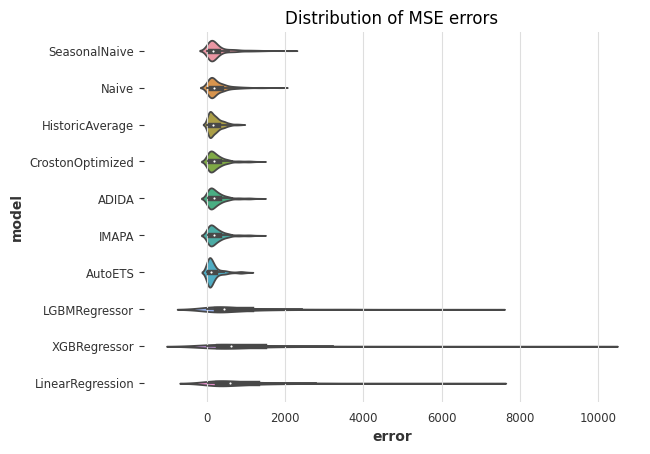

In [96]:
sns.violinplot(evaluation_df_melted.query('metric=="mse"'), x='error', y='model').set_title('Distribution of MSE errors')


## Distribution of SMAPE errors per model, unique_id and evaluation metric

Text(0.5, 1.0, 'Distribution of SMAPE errors')

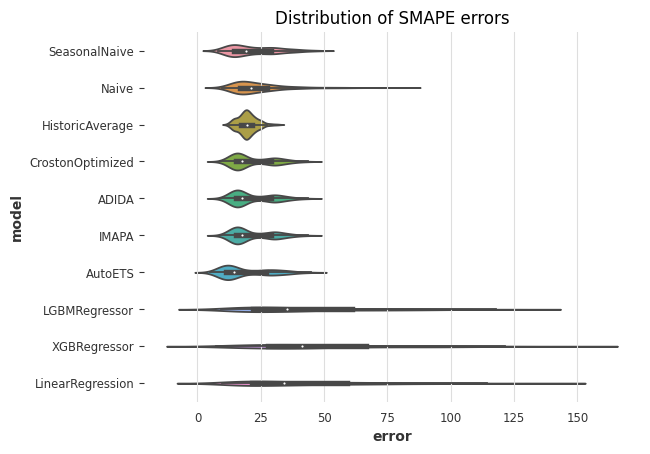

In [97]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model').set_title('Distribution of SMAPE errors')


In [98]:
trained_models = list(evaluation_df_melted.model.unique())

# Choose Best Model

In [99]:
evaluation_df[trained_models] = evaluation_df[trained_models].astype(float)
evaluation_df

,unique_id,cutoff,metric,SeasonalNaive,Naive,HistoricAverage,CrostonOptimized,ADIDA,IMAPA,AutoETS,LGBMRegressor,XGBRegressor,LinearRegression
0,1_26,2017-12-01,mse,189.633331,98.033333,125.793800,208.257904,208.257904,208.257904,157.573486,565.202942,525.581421,1664.116455
1,1_26,2017-12-01,mae,11.633333,8.700000,9.721529,12.208736,12.208736,12.208736,10.930923,22.293240,20.797604,38.954525
2,1_26,2017-12-01,mape,35.755207,26.532656,31.262075,40.555935,40.555935,40.555935,34.513111,67.545776,62.672226,114.718643
3,1_26,2017-12-01,smape,28.500648,23.340303,25.650661,30.775007,30.775007,30.775007,27.640188,47.732746,44.942799,69.370956
4,1_3,2017-12-01,mse,106.166664,50.900002,74.261719,114.982178,114.982178,114.982178,98.668747,238.811630,305.071228,943.499451
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2_47,2017-12-01,smape,26.209435,30.276388,21.227650,26.620909,26.620909,26.620909,26.533449,36.422028,60.663635,66.824516
1196,2_48,2017-11-01,mse,63.366665,126.800003,263.564331,129.887100,129.887100,129.887100,67.025726,699.711670,1101.963745,694.944519
1197,2_48,2017-11-01,mae,6.233333,9.266666,13.283425,9.179413,9.179413,9.179413,6.623496,25.319813,32.126080,24.697933
1198,2_48,2017-11-01,mape,7.940663,12.626788,15.932664,11.777508,11.777508,11.777508,8.669245,32.055767,40.784779,31.203857


# We can find the best performing model per store_item and evaluation metric

# In how many cross validation fold & metric is each model overperforming the rest?

<Axes: xlabel='n', ylabel='best_model'>

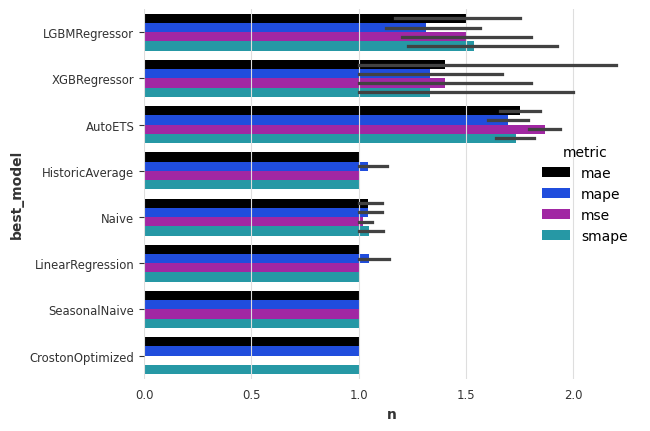

In [100]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['unique_id', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')

## AutoETS is the best performing model for all evaluation metrics

## This does not mean that AutoETS is the best performing model for each individual "store_item"

In [101]:
count_best_model

,unique_id,metric,best_model,n
0,1_1,mae,LGBMRegressor,2
1,1_1,mae,XGBRegressor,1
2,1_1,mape,LGBMRegressor,1
3,1_1,mape,XGBRegressor,2
4,1_1,mse,AutoETS,1
...,...,...,...,...
862,2_9,mape,LGBMRegressor,1
863,2_9,mse,AutoETS,2
864,2_9,mse,LinearRegression,1
865,2_9,smape,AutoETS,2


# What is the best model for store_item="1_1" bookings forecasting?

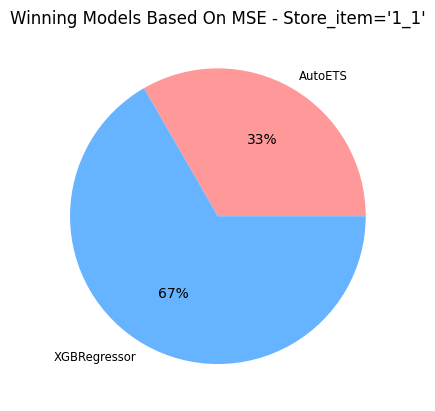

In [102]:
# For the mse, calculate how many times a model wins
#add colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
count_best_model_mse = count_best_model.query('metric == "mse" & unique_id == "1_1"')
counts_series_mse = count_best_model_mse["n"]
plt.pie(counts_series_mse, labels=count_best_model_mse["best_model"], autopct='%.0f%%', colors=colors)
plt.title("Winning Models Based On MSE - Store_item='1_1'")
plt.show()


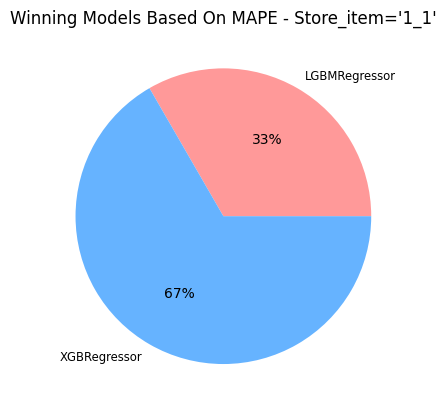

In [103]:
# For the mse, calculate how many times a model wins
count_best_model_mape = count_best_model.query('metric == "mape" & unique_id == "1_1"')
counts_series_mape = count_best_model_mape["n"]
plt.pie(counts_series_mape, labels=count_best_model_mape["best_model"], autopct='%.0f%%', colors=colors)
plt.title("Winning Models Based On MAPE - Store_item='1_1'")
plt.show()

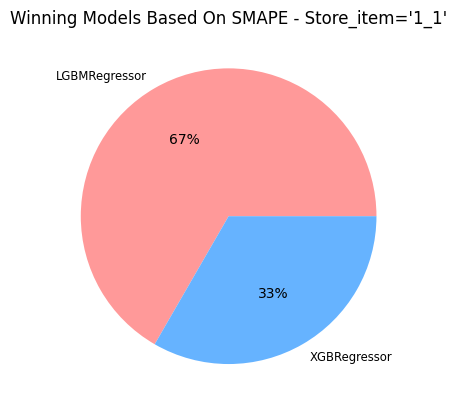

In [104]:
# For the mse, calculate how many times a model wins
count_best_model_smape = count_best_model.query('metric == "smape" & unique_id == "1_1"')
counts_series_smape = count_best_model_smape["n"]
plt.pie(counts_series_smape, labels=count_best_model_smape["best_model"], autopct='%.0f%%', colors=colors)
plt.title("Winning Models Based On SMAPE - Store_item='1_1'")
plt.show()

# Visualize the forecasts of the best model for unique_id == "1_1"

* The best model based on MAPE is XGBRegressor
* The best model based on SMAPE is LGBMRegressor

In [105]:
eval_series_df = evaluation_df.query('metric == "mape" & unique_id == "1_1"').groupby(['unique_id']).mean(numeric_only=True)
eval_series_df['best_model'] = eval_series_df.idxmin(axis=1)

sf.plot(Y_df, cv_df.drop(columns=['cutoff', 'y']), 
        max_insample_length=30 * 2, 
        models=['XGBRegressor'],
        unique_ids=eval_series_df.query('best_model == "XGBRegressor"').index[:8])

In [106]:
eval_series_df = evaluation_df.query('metric == "smape" & unique_id == "1_1"').groupby(['unique_id']).mean(numeric_only=True)
eval_series_df['best_model'] = eval_series_df.idxmin(axis=1)

sf.plot(Y_df, cv_df.drop(columns=['cutoff', 'y']), 
        max_insample_length=30 * 2, 
        models=['LGBMRegressor'],
        unique_ids=eval_series_df.query('best_model == "LGBMRegressor"').index[:8])

# Visualize the AutoETS forecasts for more unique_ids

In [107]:
eval_series_df = evaluation_df.query('metric == "mape"').groupby(['unique_id']).mean(numeric_only=True)
eval_series_df['best_model'] = eval_series_df.idxmin(axis=1)

sf.plot(Y_df, cv_df.drop(columns=['cutoff', 'y']), 
        max_insample_length=30 * 2, 
        models=['AutoETS'],
        unique_ids=eval_series_df.query('best_model == "AutoETS"').index[:8])

# Visualize the XGBRegressor forecasts for more unique_ids

In [108]:
eval_series_df = evaluation_df.query('metric == "mape"').groupby(['unique_id']).mean(numeric_only=True)
eval_series_df['best_model'] = eval_series_df.idxmin(axis=1)

sf.plot(Y_df, cv_df.drop(columns=['cutoff', 'y']), 
        max_insample_length=30 * 2, 
        models=['XGBRegressor'],
        unique_ids=eval_series_df.query('best_model == "XGBRegressor"').index[:8])

# Sources

This code is based on the following publicly available resources
* [Nixtla Statistical, Machine Learning and Neural Forecasting methods](https://nixtla.github.io/statsforecast/docs/tutorials/statisticalneuralmethods.html)
* [Intro to Forecasting with Darts](https://github.com/unit8co/darts/blob/master/examples/00-quickstart.ipynb)
* [Store Item Demand Forecasting Challenge dataset from Kaggle](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=train.csv) 